In [1]:
import os
import rasterio as rio
import numpy as np
import shapely
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array
import sklearn
from sklearn.linear_model import LinearRegression

import sys
sys.path.append('../')
import snowFun

In [2]:
# define folder and file paths
folder_AGVA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"AGVA")
folder_dems = os.path.join(folder_AGVA, "DEMs", "time_varying_DEMs", "10m")
folder_class = os.path.join(folder_AGVA, 'classified images', 'S2_Classified_Cloudmasked_Merged')
folder_cloud = os.path.join(folder_AGVA, 'classified images', 'S2_Cloud_Merged')
folder_meta = os.path.join(folder_AGVA, "classified images", "meta csv", "S2")

# open rgi
path_rgi = os.path.join(folder_AGVA, 'RGI', "rgi_2km_o3regions", "rgi_2km_o3regions.shp")
rgi_gdf = gpd.read_file(path_rgi, drop='geometry')

In [3]:
### choose if you want to do only the 45 validation glaciers
validation_only = 1

# open list of validation glaciers
all_validation_df = pd.read_csv(os.path.join(folder_AGVA, 'Validation', 'Validation Glaciers.csv'))

### get list of all the glaciers for which we have calculated the snow covered fractions
# select which rgis to analyze
if validation_only:
    folder_ela = os.path.join(folder_AGVA, 'Derived products', 'S2', 'Validation', 'ELAs')
    folder_save = os.path.join(folder_AGVA, 'Derived products', 'S2', 'Validation')
else:
    folder_sca = os.path.join(folder_AGVA, 'Derived products', 'S2', 'ELAs')
    folder_save = os.path.join(folder_AGVA, 'Derived products', 'S2')

# load rgi names that have been saved to the classified folder
rgis_to_analyze = list(set( [ i[:14] for i in os.listdir(folder_ela) if i!='merged.vrt' ] ))
# rgis_to_analyze.sort()

# get list of glacier area for each rgi
areas = [rgi_gdf[rgi_gdf['RGIId']==i]['Area'].values for i in rgis_to_analyze]

# make df
rgis_to_analyze_df = pd.DataFrame({"RGIId":rgis_to_analyze, 'Area':areas})

# sort however you want
rgis_to_analyze_df = rgis_to_analyze_df.sort_values('Area')

# grab rgi names
rgis_to_analyze = rgis_to_analyze_df['RGIId'].values

print(len(rgis_to_analyze_df))
# print(rgis_to_analyze[:10])
# print(rgis_to_analyze_df[:10])

45


In [5]:
skip = 0
for i in range(len(rgis_to_analyze)):
#     if i!=10: continue
    # subset rgi to single outline, by choosing rgiid or rgi name
    rgiid = rgis_to_analyze[i]
    if rgiid!='RGI60-01.15731': continue
        
    rgiid = rgis_to_analyze[i]
    # check if we've already run this glacier. if so, skip
    temp_path = os.path.join(folder_save, 'Annual AAs', 'csv', f"S2_{rgiid}_2018_2022_annual_AAs.csv")
#     if os.path.exists(temp_path):
#         continue

    # quickly grab glacier area
    ga = rgi_gdf[rgi_gdf['RGIId']==rgiid]['Area'].values[0]

    if ga>300: continue
    
    # print progress
    print(f"\nStarting {i+1} of {len(rgis_to_analyze)}: {rgiid}  {ga} km2")
    
    # open the ela dataframe
    path_open = os.path.join(folder_save, "ELAs", f"{rgiid}_ELAs.csv")
    ela_df = pd.read_csv(path_open)
    
#     print(ela_df)
    
    # throw out anything that has <XYZ% observed
    ela_df_good = ela_df[ela_df['observed_after_smoothing']>0.7]
    ela_df_good = ela_df_good[ela_df_good['observed_initial']>0.3]
    
    # now for each year, get the maximum ela
    annual_best = []
    
    bad_dates = []
    bad_elas = []
    expected_elas = []
    bad_dates2 = []
    bad_elas2 = []
    expected_elas2 = []
    
    for y in [2018,2019,2020,2021,2022]:
#         if y!=2020: continue
        print(y)
        # decide which of the columns you are going to want to save
        cols_to_save = ['date', 'ela', 'observed_after_smoothing', 'aar', 'off_glacier']
        
        # subset to this year. note we only consider obs in the july-november time frame
        elas_this_year = ela_df_good[ (ela_df_good['date']>=f'{y}-07-01') & (ela_df_good['date']<f'{y}-12-01')].copy()
        
#         print(elas_this_year.shape)
        # add doy
        elas_this_year['date_dt'] = [datetime.strptime(i, "%Y-%m-%d") for i in elas_this_year['date'] ]
        elas_this_year['doy'] = [i.timetuple().tm_yday for i in elas_this_year['date_dt'] ]
        
        # if len=0, we have no good data so we save a null point
        n_obs = len(elas_this_year)
        if n_obs==0:
            annual_best.append(pd.Series({"date":f"{y}-01-01", "ela":-9999, 'fraction_observed':-9999, 'aar':-9999, 'off_glacier':-9999}))
        
        # else we decide which the best of the elas is and save that info
        else:
            
            ### filter out the ELA outliers
            for idx, row in elas_this_year.iterrows():
                
                # grab all obs in the 7-30 day preceding window
                # (due ot temporal smoothing we might have info being shared within past few days that we want to avoid)
                obs_past_30 = elas_this_year[ elas_this_year['doy'] >= (row['doy']-60) ]
                obs_past_30 = obs_past_30[ obs_past_30['doy'] < (row['doy']-1) ]

                # if there are no other obs in the past 30 days, we just need to trust that this is real
                if len(obs_past_30)<3:
                    continue

                else:
                    # line of best fit to these obs (predict ela from doy)
                    X = obs_past_30['doy'].values.reshape(-1, 1)
                    y = obs_past_30['ela']
                    y2 = obs_past_30['aar']
                    bestfit = LinearRegression().fit(X, y)

                    # predict the ela on this date from that fit
                    pred = bestfit.predict(np.array(row['doy']).reshape(-1, 1))

                    # calculate difference
                    ela_diff = row['ela']-pred
#                     print(f"Predicted:{pred} Observed:{ela_max_best['ela']}")

                    # if we within a reasonable range, then we say this is a good observation and save it
                    tolerance=200
                    if ela_diff<=tolerance:
                        continue
                    
                    # or if we predicted a negative slope, then all bets are off
                    elif bestfit.coef_[0]<0:
                        continue
                        
                    # of if the date range of all the obs used to predict are too tight, then we can't throw it out
                    elif (np.nanmax(obs_past_30['doy'])-np.nanmin(obs_past_30['doy']))<15:
                        continue

                    # otherwise, we remove this row because it's bad
                    else:
                        bad_dates.append(row['date'])
                        bad_elas.append(row['ela'])
                        expected_elas.append(pred)
                        elas_this_year.drop(idx, inplace=True) 
                   
                
                
            ### filter out the AAR outliers
            for idx, row in elas_this_year.iterrows():
                
                # grab all obs in the 7-30 day preceding window
                # (due ot temporal smoothing we might have info being shared within past few days that we want to avoid)
                obs_past_30 = elas_this_year[ elas_this_year['doy'] >= (row['doy']-60) ]
                obs_past_30 = obs_past_30[ obs_past_30['doy'] < (row['doy']-1) ]

                # if there are no other obs in the past 30 days, we just need to trust that this is real
                if len(obs_past_30)<3:
                    continue

                else:

                    # line of best fit to these obs (predict ela from doy)
                    X = obs_past_30['doy'].values.reshape(-1, 1)
                    y = obs_past_30['ela']
                    y2 = obs_past_30['aar']
                    bestfit = LinearRegression().fit(X, y2)

                    # predict the ela on this date from that fit
                    pred = bestfit.predict(np.array(row['doy']).reshape(-1, 1))

                    # calculate difference
                    aar_diff = row['aar']-pred
#                     print(f"Predicted:{pred} Observed:{ela_max_best['ela']}")

                    # if we within a reasonable range, then we say this is a good observation and save it
                    tolerance=-0.15
                    if aar_diff>=tolerance:
                        continue
                    
                    # or if we predicted a positive slope, then all bets are off
                    elif bestfit.coef_[0]>0:
                        continue
                        
                    # of if the date range of all the obs used to predict are too tight, then we can't throw it out
                    elif (np.nanmax(obs_past_30['doy'])-np.nanmin(obs_past_30['doy']))<10:
                        continue

                    # otherwise, we remove this row because it's bad
                    else:
                        bad_dates2.append(row['date'])
                        bad_elas2.append(row['aar'])
                        expected_elas2.append(pred)
                        elas_this_year.drop(idx, inplace=True) 

                        
                        
                        
#             print(elas_this_year.shape)
            
            # find the maximum ela
            ela_max = np.nanmax(elas_this_year['ela'])

            # get all the dates that had this ela
            ela_max_all = elas_this_year[elas_this_year['ela']==ela_max]

            # we'll take the one that has the minimum aar to be the 'best' estimate
            # for example, if the ela is well above the glacier, there are likely many dates with the same ela found
            ela_max_best = ela_max_all.loc[ela_max_all['aar'].idxmin()]
            
            # find the minimum aar
            aar_min = np.nanmin(elas_this_year['aar'])
            aar_min_all = elas_this_year[elas_this_year['aar']==aar_min]
            aar_min_best = aar_min_all.loc[aar_min_all['ela'].idxmax()]
            
            # choose which to use
            best = ela_max_best #ela_max_best, aar_min_best
            
            # save this data
            annual_best.append(best[cols_to_save])
            
    ### save all the data here
    
    # function to format metadata and attributes
    def format_xr_to_save(xr_da):
        xr_da.attrs["res"] = (10,10)
        xr_da.attrs["crs"] = "EPSG:3338"
        xr_da.attrs["transform"] = [10,0,0,0,-10,0]
        xr_da.attrs["_FillValue"] = 0
        xr_da.attrs["long_name"] = rgiid
        xr_da.attrs["description"] = "0: nan, 1: ablation, 2: accumulation"
        xr_da.name = "accumulation_area"

        xr_da.x.attrs["units"] = "meters"
        xr_da.y.attrs["units"] = "meters"
        xr_da.x.attrs["long_name"] = 'x'
        xr_da.y.attrs["long_name"] = 'y'

        return xr_da
    
    # set folder paths, etc...
    print(rgiid)
    path_df_all = os.path.join(folder_save, 'Annual AAs', 'csv', f"S2_{rgiid}_2018_2022_annual_AAs.csv")
    path_xr_all = os.path.join(folder_save, 'Annual AAs', f"S2_{rgiid}_2018_2022_annual_AAs.nc")
    path_xr_avg = os.path.join(folder_save, 'Average AAs', f"S2_{rgiid}_2018_2022_average_AA.nc")
    path_tif_avg = os.path.join(folder_save, 'Average AAs', f"S2_{rgiid}_2018_2022_average_AA.tif")
    
    # one year at a time, get the snow distributions
    all_maps = []
    for s in annual_best:
        
        # get date
        d = s['date']
        
        # skip the null years
        if d[5:7]=='01': continue
        
        # open the snow distribution map
        if ga>500:
            path_open = os.path.join(folder_save, 'Daily AAs', f"S2_{rgiid}_{d[:4]}_daily_AAs_shadowed_coarse_smoothed.nc")
        else:
            path_open = os.path.join(folder_save, 'Daily AAs', f"S2_{rgiid}_{d[:4]}_daily_AAs_shadowed_smoothed.nc")
        
        snow = xr.open_dataset(path_open, chunks={'time':1})['class'].sel(time=d)
        all_maps.append(snow)
    
    # format to save maps as long as there is usable imagery
    if len(all_maps)>0:
        all_maps = xr.concat(all_maps, dim='time')
        average_map = all_maps.median('time', skipna=True).astype('uint8')#+glacier_mask
        save_xr_all = format_xr_to_save(all_maps.astype('uint8'))
        save_xr_avg = format_xr_to_save(average_map)

        # specify compression/encoding
        encoding = {"accumulation_area":{"zlib": True}}#, "spatial_ref":{"zlib": False}}

        # save
        save_xr_all.to_netcdf(path_xr_all, encoding=encoding)
        save_xr_avg.to_netcdf(path_xr_avg, encoding=encoding)
        save_xr_avg.rio.to_raster(raster_path=path_tif_avg, encoding=encoding)

    # always save the csv
    annual_best = pd.DataFrame(annual_best)
    annual_best.to_csv(path_df_all, index=False) # table with annual end-of-summer ela, aar, date, fraction observed

print('All done!')
print(rgiid)


Starting 37 of 45: RGI60-01.15731  40.009 km2
2018
2019
2020
2021
2022
RGI60-01.15731
All done!
RGI60-01.01390


           date     ela  observed_after_smoothing     aar  off_glacier
29   2018-09-11  1900.0                    0.8803  0.5944        False
74   2019-07-13  2490.0                    0.7175  0.5039        False
135  2020-08-23  2040.0                    0.8446  0.5708        False
191  2021-08-31  1870.0                    0.8137  0.6208        False
234  2022-08-03  1930.0                    0.9014  0.5967        False


Text(0.5, 0.98, 'RGI60-01.01390')

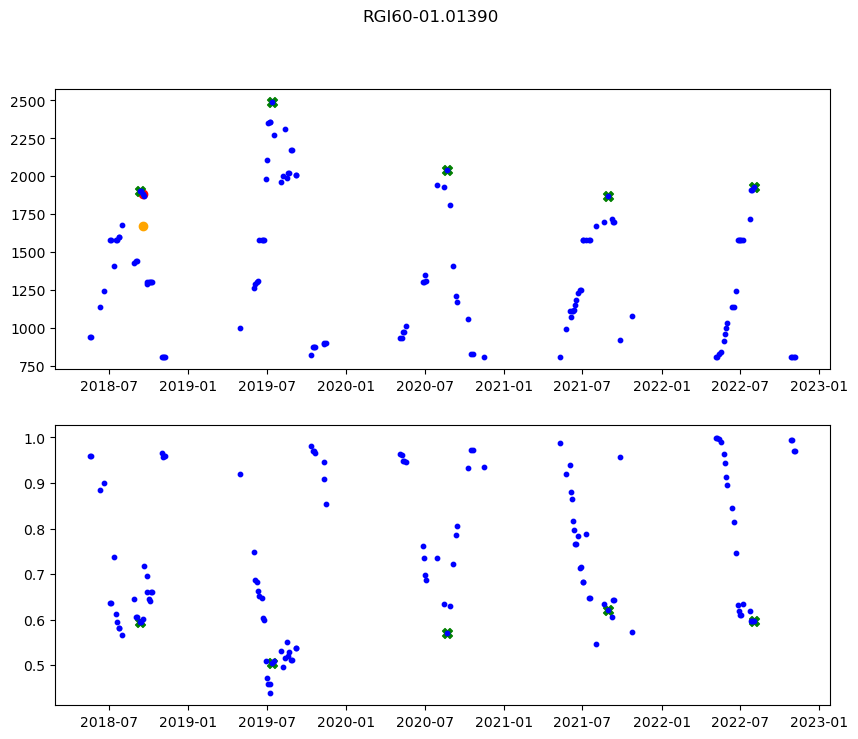

In [6]:
print(annual_best)
fig,axs = plt.subplots(2,1, figsize=(10,8))
marker = 'o'
size = 10
color='blue'
axs[0].scatter(pd.to_datetime(ela_df_good['date']), ela_df_good['ela'], marker=marker, s=size, c=color, zorder=5)
axs[1].scatter(pd.to_datetime(ela_df_good['date']), ela_df_good['aar'], marker=marker, s=size, c=color, zorder=5)

axs[0].scatter(pd.to_datetime(bad_dates), bad_elas, c='red')
axs[0].scatter(pd.to_datetime(bad_dates), expected_elas, c='orange')

axs[1].scatter(pd.to_datetime(bad_dates2), bad_elas2, c='red')
axs[1].scatter(pd.to_datetime(bad_dates2), expected_elas2, c='orange')
    
marker = 'X'
size = 50
color='green'
axs[0].scatter(pd.to_datetime(annual_best['date']), annual_best['ela'], marker=marker, s=size, c=color, zorder=1)
axs[1].scatter(pd.to_datetime(annual_best['date']), annual_best['aar'], marker=marker, s=size, c=color, zorder=1)

plt.suptitle(rgiid)

In [9]:
ela_df_good.head(50)

,date,ela,fraction_observed_slopemasked,aar,off_glacier,observed_initial,terrain_shadows,observed_after_smoothing
4,2018-05-19,940.0,0.8478,0.9585,False,0.7937,0.0063,0.8555
5,2018-05-21,940.0,0.8478,0.9585,False,0.3025,0.0059,0.8555
9,2018-06-10,1140.0,0.7571,0.8842,False,0.3632,0.0025,0.7628
11,2018-06-20,1240.0,0.6957,0.9003,False,0.5177,0.0023,0.7352
13,2018-07-03,1580.0,0.8958,0.6363,False,0.8714,0.0030,0.9051
14,2018-07-05,1580.0,0.8958,0.6363,False,0.7593,0.0032,0.9051
15,2018-07-13,1410.0,0.7294,0.7382,False,0.7291,0.0039,0.7364
17,2018-07-18,1580.0,0.9139,0.6124,False,0.7934,0.0048,0.9190
18,2018-07-20,1580.0,0.9311,0.5956,False,0.8449,0.0055,0.9344
19,2018-07-23,1600.0,0.9222,0.5827,False,0.8821,0.0062,0.9253
